In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Output from ResNet as a confidence value;
# (Optional) Dropout; Temp. scal; Ensambles
# (Optional) was wollen wir messen? 

In [ ]:
#https://medium.com/towards-artificial-intelligence/resnet-architecture-deep-learning-with-pytorch-19ecb7ca359e

import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

#%matplotlib inlineproject_name='05b-cifar10-resnet'

In [ ]:
#https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Calibration/data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Calibration/data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, (45000, 5000))


Files already downloaded and verified


In [ ]:
batch_size = 100
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
print(model)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
model_dir = '/content/drive/MyDrive/Calibration/model/ResNet'
torch.save(model.state_dict(), '{}'.format(model_dir))

Epoch [1/80], Step [100/450] Loss: 1.5265
Epoch [1/80], Step [200/450] Loss: 1.5014
Epoch [1/80], Step [300/450] Loss: 1.2019
Epoch [1/80], Step [400/450] Loss: 1.1283
Epoch [2/80], Step [100/450] Loss: 1.0310
Epoch [2/80], Step [200/450] Loss: 0.9156
Epoch [2/80], Step [300/450] Loss: 0.8075
Epoch [2/80], Step [400/450] Loss: 0.9129
Epoch [3/80], Step [100/450] Loss: 0.7706
Epoch [3/80], Step [200/450] Loss: 0.8670
Epoch [3/80], Step [300/450] Loss: 0.7661
Epoch [3/80], Step [400/450] Loss: 0.8897
Epoch [4/80], Step [100/450] Loss: 0.7142
Epoch [4/80], Step [200/450] Loss: 0.7421
Epoch [4/80], Step [300/450] Loss: 0.7475
Epoch [4/80], Step [400/450] Loss: 0.6584
Epoch [5/80], Step [100/450] Loss: 0.7693
Epoch [5/80], Step [200/450] Loss: 0.6061
Epoch [5/80], Step [300/450] Loss: 0.6701
Epoch [5/80], Step [400/450] Loss: 0.6987
Epoch [6/80], Step [100/450] Loss: 0.5285
Epoch [6/80], Step [200/450] Loss: 0.7538
Epoch [6/80], Step [300/450] Loss: 0.6939
Epoch [6/80], Step [400/450] Loss:

In [ ]:
# Save the model checkpoint
model_dir = '/content/drive/MyDrive/Calibration/model/ResNet'
torch.save(model.state_dict(), '{}'.format(model_dir))

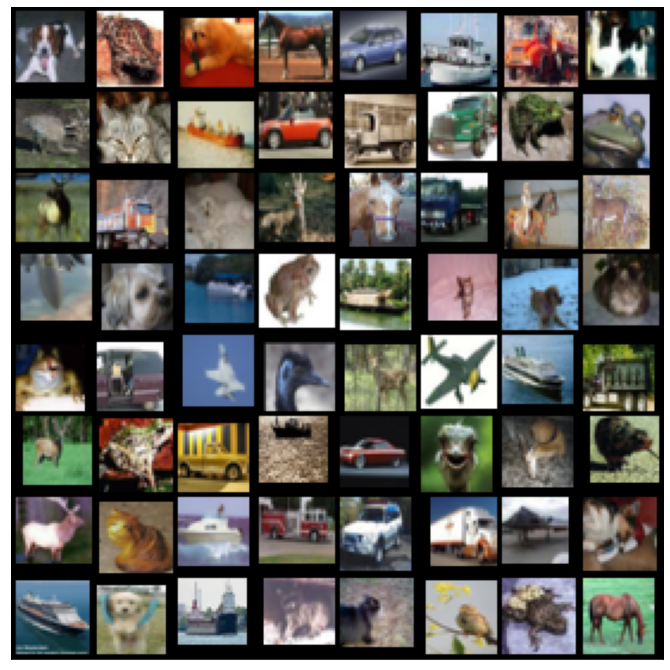

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_loader)

[0.9999381890636071, 0.6570607218594307, 0.9386340942967262, 0.9602475449843629, 0.7435731315200458, 0.9999897474965059, 0.9588961090530899, 0.9288847398352961, 0.998972338710809, 0.9999720413872211, 0.8424152908383425, 0.9826802445994486, 0.8567469854806845, 0.9992038022414896, 0.9999998860250956, 0.9999287986452894, 0.9997531825154023, 0.9998207755242171, 0.9455592032800534, 0.9998541687976884, 0.9977289616152082, 0.9808619290089198, 0.9998532804654294, 0.9740275728033023, 0.998309315296581, 0.9990542629021882, 0.9755052443867622, 0.9928431446238604, 0.7243352082169398, 0.999701182302474, 0.9996555657828666, 0.9998966623843966, 0.9999981122439474, 0.9926515350919574, 0.9681496315048681, 0.9996255817260024, 0.9999999542628054, 0.9997362148943469, 0.9999940992942833, 0.9984515223301895, 0.9999559709118364, 0.999998374812616, 0.9999882406455112, 0.604972613440478, 0.9700116561479971, 0.9998591431029823, 0.920565491047074, 0.6076085041452176, 0.9996248906688063, 0.8446893089024372, 0.999

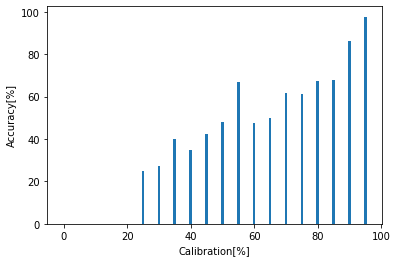

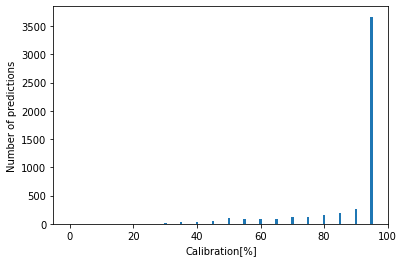

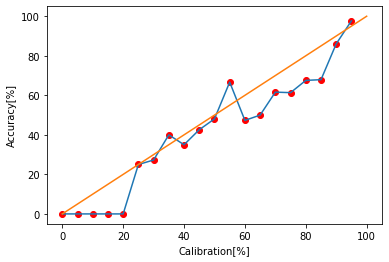

Accuracy of the model on the test images: 88.48 %
Die Durchschnittliche Calibration des Modells ist 92.60631120007565 %


In [ ]:
#images = Tensor mit 100 Bildern
#labels = Tensor mit 100 Labels
#outputs = Tensor mit 100 Vektoren mit Dimension 10, die 10 Dimensioen representieren vermutlich zu den Labels gehörige Werte die aber teileweise negativ sind (??)
import math
#model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    calibrations = []
    buckets = []
    accuracy = []
    bucket_calibs = []
    number_of_pred =[]
    for i in range(20):
      buckets.append([])

    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        i=0
        for lists in outputs:
          calib = math.exp(np.max(list(lists)))/sum(list(map(lambda x: math.exp(x),list(lists))))
          calibrations.append(calib)
          if (0<=calib<0.05):
            if (predicted[i]==labels[i]):
              buckets[0].append(1)
            else:
              buckets[0].append(0)
          elif (0.05<=calib<0.1):
            if (predicted[i]==labels[i]):
              buckets[1].append(1)
            else:
              buckets[1].append(0)
          elif (0.1<=calib<0.15):
            if (predicted[i]==labels[i]):
              buckets[2].append(1)
            else:
              buckets[2].append(0)
          elif (0.15<=calib<0.2):
            if (predicted[i]==labels[i]):
              buckets[3].append(1)
            else:
              buckets[3].append(0)
          elif (0.2<=calib<0.25):
            if (predicted[i]==labels[i]):
              buckets[4].append(1)
            else:
              buckets[4].append(0)
          elif (0.25<=calib<0.3):
            if (predicted[i]==labels[i]):
              buckets[5].append(1)
            else:
              buckets[5].append(0)
          elif (0.3<=calib<0.35):
            if (predicted[i]==labels[i]):
              buckets[6].append(1)
            else:
              buckets[6].append(0)
          elif (0.35<=calib<0.4):
            if (predicted[i]==labels[i]):
              buckets[7].append(1)
            else:
              buckets[7].append(0)
          elif (0.4<=calib<0.45):
            if (predicted[i]==labels[i]):
              buckets[8].append(1)
            else:
              buckets[8].append(0)
          elif (0.45<=calib<0.5):
            if (predicted[i]==labels[i]):
              buckets[9].append(1)
            else:
              buckets[9].append(0)
          elif (0.5<=calib<0.55):
            if (predicted[i]==labels[i]):
              buckets[10].append(1)
            else:
              buckets[10].append(0)
          elif (0.55<=calib<0.6):
            if (predicted[i]==labels[i]):
              buckets[11].append(1)
            else:
              buckets[11].append(0)
          elif (0.6<=calib<0.65):
            if (predicted[i]==labels[i]):
              buckets[12].append(1)
            else:
              buckets[12].append(0)
          elif (0.65<=calib<0.7):
            if (predicted[i]==labels[i]):
              buckets[13].append(1)
            else:
              buckets[13].append(0)
          elif (0.7<=calib<0.75):
            if (predicted[i]==labels[i]):
              buckets[14].append(1)
            else:
              buckets[14].append(0)
          elif (0.75<=calib<0.8):
            if (predicted[i]==labels[i]):
              buckets[15].append(1)
            else:
              buckets[15].append(0)
          elif (0.8<=calib<0.85):
            if (predicted[i]==labels[i]):
              buckets[16].append(1)
            else:
              buckets[16].append(0)
          elif (0.85<=calib<0.9):
            if (predicted[i]==labels[i]):
              buckets[17].append(1)
            else:
              buckets[17].append(0)
          elif (0.9<=calib<0.95):
            if (predicted[i]==labels[i]):
              buckets[18].append(1)
            else:
              buckets[18].append(0)
          elif (0.95<=calib<=1):
            if (predicted[i]==labels[i]):
              buckets[19].append(1)
            else:
              buckets[19].append(0)
          

          i +=1

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(calibrations)
    i = 0

    for bucks in buckets:
      if len(bucks)>0:
        print("Für den Calibrationbucket mit allen Predictions mit Calibration zwischen "+str(i)+"% und "+str(i+5)+"% ist die wirkliche Accuracy:")
        print(str((sum(bucks)/(len(bucks)))*100)+"%")
        print(str(len(bucks))+" Predictions befinden sich in diesem Bucket.")
        accuracy.append((sum(bucks)/(len(bucks)))*100)
        number_of_pred.append(len(bucks))
      else:
        print("Für den Calibrationbucket mit allen Predictions mit Calibration zwischen "+str(i)+"% und "+str(i+5)+"% ist die wirkliche Accuracy nicht berechenbar da kein Inhalt")
        accuracy.append(0)
        number_of_pred.append(len(bucks))
      i=i+5
      bucket_calibs.append(i-5)
    plt.bar(bucket_calibs,accuracy)
    plt.xlabel("Calibration[%]")
    plt.ylabel("Accuracy[%]")
    plt.show()
    plt.bar(bucket_calibs,number_of_pred)
    plt.xlabel("Calibration[%]")
    plt.ylabel("Number of predictions")
    plt.show()
    plt.plot(bucket_calibs, accuracy)
    plt.scatter(bucket_calibs, accuracy, color='red')
    plt.xlabel("Calibration[%]")
    plt.ylabel("Accuracy[%]")
    x1 = 0
    x2 = 100
    y1 = 0
    y2 = 100
    plt.plot((x1, x2), (y1, y2))

    plt.show()
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("Die Durchschnittliche Calibration des Modells ist " + str((sum(calibrations)/len(calibrations))*100)+" %")

# Save the model checkpoint